In [264]:
import seaborn as sns
import pickle 
import numpy as np
import pandas as pd
import h5py
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from math import factorial
from scipy import interpolate # import interp1d, UnivariateSpline
from scipy.optimize import curve_fit
import torch 
import torch.nn as nn

SMALL_SIZE = 20
MEDIUM_SIZE = 22
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


In [2]:
# full_dict = {'all': all_dict, 'train': train_dict, 'valid': val_dict, 'test': test_dict}
# all_dict = {'raw': {'X': [], 'y': [], 'mask': [], 'radii': []}}

with open('/home/kitadam/ENR_Sven/moxie/data/processed/raw_masked_shifted_w_radii.pickle', 'rb') as file: 
    full_dict = pickle.load(file)

In [120]:
train_dict = full_dict['train']['raw']
val_dict = full_dict['valid']['raw']
test_dict = full_dict['test']['raw']
all_dict = full_dict['all']['raw']

all_X, all_y, all_mask, all_radii = all_dict.values()
train_X, train_y, train_mask, train_radii = train_dict.values()
val_X, val_y, val_mask, val_radii = val_dict.values()
test_X, test_y, test_mask, test_radii = test_dict.values()

### Some early statistics 

- The profiles are unevenly sized, with spacings distrubted as so: 
    - Num Measurements in slice: Num Slices with those number of measurments 
        - 23: 57967 (train: 42021, val: 10243, test: 5703)
        - 22: 3670 (train: 2726, val: 723, test: 221)
        - 24: 7458 (train: 5213, val: 1495, test: 750)
        - 21: 668 (train: 530, val: 112, test: 26) 
        - 20: 11579 (train: 8328, val: 1945, test: 1306) 
        - 19: 743 (train: 496, val: 168, test: 79) 
        - 18: 1 (train: 1, val: 0, test: 0) 
    - Most have 23 measurements, followed by 20
    - **Max length: 24, Min length: 18**

In [46]:
print('\n# X Types', type(train_X), type(train_X[0]), train_X[0].dtype)
print('\n# y (machine params) Types', type(train_y), type(train_y[0]), train_y[0].dtype)
print('\n# mask Types', type(train_mask), type(train_mask[0]), train_mask[0].dtype)
print('Depending how you want to do this, might need to convert to boolean')
print('\n# radii Types', type(train_radii), type(train_radii[0]), train_radii[0].dtype)


# X Types <class 'list'> <class 'numpy.ndarray'> float32

# y (machine params) Types <class 'list'> <class 'numpy.ndarray'> float32

# mask Types <class 'list'> <class 'numpy.ndarray'> float32
Depending how you want to do this, might need to convert to boolean

# radii Types <class 'list'> <class 'numpy.ndarray'> float32


In [417]:
k = 518
sample_X, sample_y, sample_mask, sample_radii = train_X[k], train_y[k], train_mask[k], train_radii[k]
sample_mask = np.array(sample_mask, dtype=bool)
sample_D, sample_T = sample_X[0], sample_X[1]
print(sample_D, sample_T, sample_mask)

[7.5658565e+19 7.6453292e+19 7.6078394e+19 7.6535949e+19 7.4200234e+19
 7.0497950e+19 7.0571692e+19 7.5179389e+19 6.8764139e+19 7.3578979e+19
 7.6886693e+19 7.3744715e+19 7.1898591e+19 6.8922002e+19 6.4835557e+19
 5.5276883e+19 2.1879142e+19 0.0000000e+00 1.3183925e+19 2.8436801e+18
 0.0000000e+00 0.0000000e+00 0.0000000e+00] [1520.5142   1489.8138   1369.115    1214.2618   1400.1061   1427.6671
 1195.9938   1187.254    1245.317     868.90814   968.96      982.507
  866.7276    783.34424   731.9931    426.46826   139.64282     0.
   10.111556   14.117011    0.          0.          0.      ] [False False False False False False False False False False False False
 False False False False False False False False False False False]


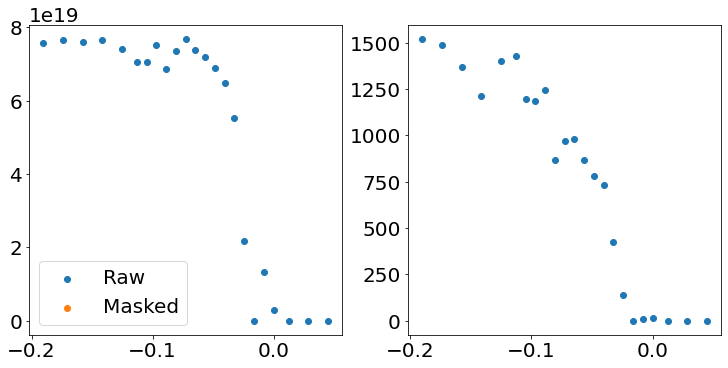

In [413]:
fig, axs = plt.subplots(1,2, figsize=(10, 5), constrained_layout=True)
axs[0].scatter(sample_radii, sample_D, label='Raw')
axs[0].scatter(sample_radii[sample_mask], sample_D[sample_mask], label='Masked')
axs[1].scatter(sample_radii, sample_T)
axs[1].scatter(sample_radii[sample_mask], sample_T[sample_mask])
axs[0].legend()
plt.show()

# How to get from Raw to ML

## When each sequence MUST or SHOULD be the same size
- **(a)** Pad raws and add to mask (add null values that do not propogate loss)
    - This may be problematic for the convolution layers and how they learn
- **(b)** Fit data 
    - Fit using MTANH fit    
    
## Keep it raw (uneven sized)

- Could custom make a data loader which collates like sized samples into batches then randomly samples from the batches   
    - Organize
    
- Encoding into latent space needs constant sized linear layers
    - AdaptiveAvgPool1d reduces the output of any convolution to a constant value 
- Decoding
    - This is a problem

In [443]:
# Padding the raws so they are the same size for all: 
def pad_raw_profs(X, y, mask, radii):
    padded_profs = []
    padded_masks = []
    padded_radii = []
    for n, (samp_X, samp_MP, samp_Mask, samp_radius) in enumerate(zip(X, y, mask, radii)): 
        samp_D, samp_T = samp_X[0], samp_X[1]
        if len(sample_D) < 24:
            D_padded = np.pad(samp_D, pad_width=(24-len(samp_D), 0), mode='mean', stat_length=2)
            T_padded = np.pad(samp_T, pad_width=(24-len(samp_D), 0), mode='mean', stat_length=2)
            padded_mask = np.pad(samp_Mask, pad_width=(24-len(samp_D), 0), mode='constant', constant_values=0.0)
            padded_radius = np.pad(samp_radius, pad_width=(24-len(samp_D), 0), mode='edge')
        else: 
            D_padded, T_padded = samp_D, samp_T
            padded_mask = samp_Mask
            padded_radius = samp_radius
        padded_profs.append(np.vstack([D_padded, T_padded]))
        padded_masks.append(padded_mask)
        padded_radii.append(padded_radius)
    stacked_padded_profs = np.stack(padded_profs, 0)
    stacked_masks = np.stack(padded_masks, 0)
    stacked_radii = np.stack(padded_radii, 0)
    return stacked_padded_profs, stacked_masks, stacked_radii 
# MATANH Fit of profile

def fit_profs(X, y, mask, radii, plotting=False): 
    
    def MTANH(r, p, w, s, h1, h0):
        x = (p-(r+1.0)) / (w/2)
        
        numerator = (1 + s*x)*np.exp(x) - np.exp(-x)
        denominator = np.exp(x) + np.exp(-x)
        # print(x)
                       
        return (h1 - h0) / 2.0 *(numerator/denominator + 1) + h0
    
    fitted_profs = []
    common_axis = np.linspace(-0.175, 0.05)
    for n, (samp_X, samp_MP, samp_Mask, samp_radius) in enumerate(zip(X, y, mask, radii)): 
        try: 
            samp_D, samp_T = samp_X[0], samp_X[1]
            samp_Mask_bool = np.array(samp_Mask, dtype=bool)
            samp_Mask_bool = np.invert(samp_Mask_bool)
            samp_D_reduced = samp_D*1e-19
            samp_T_reduced = samp_T*1e-3
            D_popt, D_pcovt = curve_fit(MTANH, samp_radius[samp_Mask_bool], samp_D_reduced[samp_Mask_bool], method='trf', maxfev=6000, check_finite=False)
            T_popt, T_pcovt = curve_fit(MTANH, samp_radius[samp_Mask_bool], samp_T_reduced[samp_Mask_bool], method='trf',check_finite=False, maxfev=6000)
            
            D_fitted = MTANH(common_axis, *D_popt)*1e20
            T_fitted = MTANH(common_axis, *T_popt)*1e3
            fitted_profs.append(np.vstack([D_fitted, T_fitted]))
        
        
        except RuntimeError as e: 
            print(n)
            print(e)
            continue
        except ValueError as enew: 
            print(n)
            print(enew)
            continue
    stacked_fitted_profs = np.stack(fitted_profs, 0) 
    return stacked_fitted_profs
    
    

In [ ]:
all_y = np.stack(all_y)
train_y = np.stack(train_y)
val_y = np.stack(val_y)
test_y = np.stack(test_y)

In [ ]:
all_fitted_X = fit_profs(all_X, all_y, all_mask, all_radii)
train_fitted__X= fit_profs(train_X, train_y, train_mask, train_radii)
val_fitted__X= fit_profs(val_X, val_y, val_mask, val_radii)
test_fitted__X= fit_profs(test_X, test_y, test_mask, test_radii)

In [444]:
all_padded_X, all_padded_masks, all_padded_radii = pad_raw_profs(all_X, all_y, all_mask, all_radii)
train_padded_X, train_padded_masks, train_padded_radii = pad_raw_profs(train_X, train_y, train_mask, train_radii)
val_padded_X, val_padded_masks, val_padded_radii = pad_raw_profs(val_X, val_y, val_mask, val_radii)
test_padded_X, test_padded_masks, test_padded_radii = pad_raw_profs(test_X, test_y, test_mask, test_radii)

In [483]:
# all_fitted_X[:, 1] = all_fitted_X[:, 1]*1e6
train_padded_X[:, 1] = train_padded_X[:, 1]*1e-6
val_padded_X[:, 1] =  val_padded_X[:, 1]*1e-6
test_padded_X[:, 1]  =  test_padded_X[:, 1]*1e-6

train_fitted__X[:, 1] = train_fitted__X[:, 1]*1e6
val_fitted__X[:, 1] = val_fitted__X[:, 1]*1e6
test_fitted__X[:, 1] = test_fitted__X[:, 1]*1e6

# Te needs to be multiplied by 1e6!!!!!!!

In [484]:
all_dict = {'raw': {'X': all_X, 'y': all_y, 'mask': all_mask, 'radii': all_radii}, # all_X, all_y, all_mask, all_radii
           'padded': {'X': all_padded_X, 'y': all_y, 'mask': all_padded_masks, 'radii': all_padded_radii}, 
           'fitted': {'X': all_fitted_X, 'y': all_y, 'mask': None, 'radii': np.linspace(-0.175, 0.05)}}


train_dict = {'raw': {'X': train_X, 'y': train_y, 'mask': train_mask, 'radii': train_radii}, # all_X, all_y, all_mask, all_radii
           'padded': {'X': train_padded_X, 'y': train_y, 'mask': train_padded_masks, 'radii': train_padded_radii}, 
              'fitted': {'X': train_fitted__X, 'y': train_y, 'mask': None, 'radii': np.linspace(-0.175, 0.05)}
             }

val_dict =  {'raw': {'X': val_X, 'y': val_y, 'mask': val_mask, 'radii': val_radii}, # all_X, all_y, all_mask, all_radii
           'padded': {'X': val_padded_X, 'y': val_y, 'mask': val_padded_masks, 'radii': val_padded_radii}, 
            'fitted': {'X': val_fitted__X, 'y': val_y, 'mask': None, 'radii': np.linspace(-0.175, 0.05)}}

test_dict = {'raw': {'X': test_X, 'y': test_y, 'mask': test_mask, 'radii': test_radii}, # all_X, all_y, all_mask, all_radii
           'padded': {'X': test_padded_X, 'y': test_y, 'mask': test_padded_masks, 'radii': test_padded_radii}, 
            'fitted': {'X': test_fitted__X, 'y': test_y, 'mask': None, 'radii': np.linspace(-0.175, 0.05)}}

full_dict = {'all': all_dict, 'train': train_dict, 'valid': val_dict, 'test': test_dict}

In [485]:
with open('/home/kitadam/ENR_Sven/moxie/data/processed/raw_padded_fitted_datasets.pickle', 'wb') as file: 
    pickle.dump(full_dict, file)

In [462]:
# Some more statistics
average_tesep = np.zeros((len(all_X), 2))
average_nesep = np.zeros((len(all_X), 2))

for n, (samp_X, samp_MP, samp_Mask, samp_radius) in enumerate(zip(all_fitted_X, all_y, all_mask, all_radii)): 
    samp_D, samp_T = samp_X[0]*1e-20, samp_X[1]*1e6 # Density and Temperature
    samp_radius = np.linspace(-0.175, 0.05)
    
    sep_mask = np.logical_and(samp_radius > -0.02, samp_radius < 0.02)
    # samp_Mask_bool = np.array(samp_Mask, dtype=bool)
    
    # sep_mask = np.logical_and(sep_mask_loc, np.invert(samp_Mask_bool))
    
    d_mean, d_std = np.mean(samp_D[sep_mask]), np.std(samp_D[sep_mask])
    t_mean, t_std = np.mean(samp_T[sep_mask]), np.std(samp_T[sep_mask])
    
    if d_mean == np.inf or t_mean == np.inf: 
        print('Infinite mean', d_mean, t_mean)
        continue
    if d_std == np.inf or t_std == np.inf: 
        print('Infinite std', d_std, t_std, samp_D[sep_mask])
        continue
    if d_mean == -np.inf or t_mean == -np.inf: 
        print('Infinite mean', d_mean, t_mean)
        continue
    if d_std == -np.inf or -t_std == np.inf: 
        print('Infinite std', d_std, t_std, samp_D[sep_mask])
        continue
    average_nesep[n, 0], average_nesep[n, 1] = np.mean(samp_D[sep_mask]), np.std(samp_D[sep_mask])
    average_tesep[n, 0], average_tesep[n, 1] = np.mean(samp_T[sep_mask]), np.std(samp_T[sep_mask])

In [477]:
average_tseps = np.mean(all_fitted_X[:, 1,np.logical_and(samp_radius > -0.02, samp_radius < 0.02)]*1e6, 1)
average_tseps = average_tseps[np.logical_not(np.isnan(average_tseps))]
np.mean(average_tseps), np.std(average_tseps)

(55.47196341804332, 137.93945138903254)

# Mean nesep  5.852115914989733e+19 +- 5.6091045035473445e+19
# Mean Tesep  nan +- nan


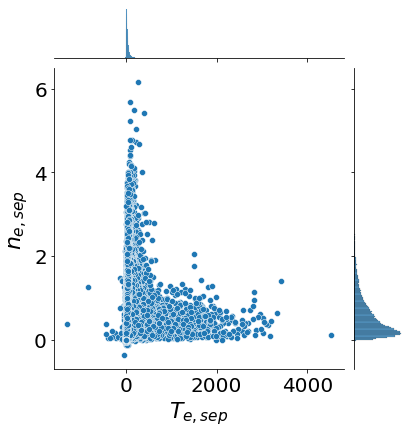

In [463]:
print('# Mean nesep ', 1e20*np.mean(average_nesep[:, 0]), '+-', 1e20*np.std(average_nesep[:, 0]))
print('# Mean Tesep ', np.mean(average_tesep[:, 0]), '+-', np.std(average_tesep[:, 0]))
ax = sns.jointplot(x=average_tesep[:, 0], y=average_nesep[:, 0])
ax.set_axis_labels(xlabel='$T_{e, sep}$', ylabel='$n_{e, sep}$')

plt.show()

# Mean nesep  5.914832579154738e+18 +- 5.906199502483414e+18
# Mean Tesep  83.32836036910365 +- 302.6110322381214


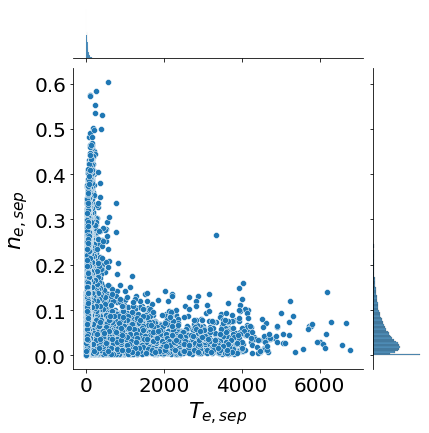

In [232]:
# average_nesep *= 1e-20
# average_nesep_raw = np.copy(average_nesep)
# average_tesep_raw = np.copy(average_tesep)
print('# Mean nesep ', 1e20*np.mean(average_nesep_raw[:, 0]), '+-', 1e20*np.std(average_nesep_raw[:, 0]))
print('# Mean Tesep ', np.mean(average_tesep_raw[:, 0]), '+-', np.std(average_tesep_raw[:, 0]))
ax = sns.jointplot(x=average_tesep_raw[:, 0], y=average_nesep_raw[:, 0])
ax.set_axis_labels(xlabel='$T_{e, sep}$', ylabel='$n_{e, sep}$')

plt.show()

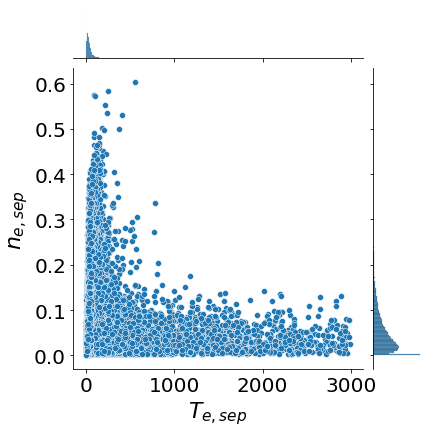

In [230]:
# fig, axs = plt.subplots(1, 2, figsize=(10, 5), constrained_layout=True)

# axs[0].hist(average_nesep[:, 0]*1e20, bins=50)
# axs[1].hist(average_tesep[:, 0], bins=50)
# plt.show()

# sns.displot(average_nesep[:, 0]*1e20)
# sns.displot(average_tesep[:, 0], kde=True)
# plt.figure(figsize=(20,10))
ax = sns.jointplot(x=average_tesep[:, 0], y=average_nesep[:, 0])
ax.set_axis_labels(xlabel='$T_{e, sep}$', ylabel='$n_{e, sep}$')

plt.show()

In [104]:
sample_batch = train_X[100:105]
sample_batch = np.array(sample_batch)
# print(sample_batch)
print('Convert to a float32 numpy array')
print('Before', sample_batch.dtype, sample_batch.shape)
batch_D = np.vstack(sample_batch[:, 0]).astype(np.float32)
batch_T = np.vstack(sample_batch[:, 1]).astype(np.float32)
batch_converted = np.stack([batch_D, batch_T], 1)
# print(batch_D.shape)
# sample_batch_conv = np.array(list(sample_batch[:]), dtype=np.float32)
print('After', batch_converted.dtype, batch_converted.shape)

Convert to a float32 numpy array
Before object (5, 2)
After float32 (5, 2, 23)


In [110]:
batch_tensor = torch.from_numpy(batch_converted)
simple_conv_block = nn.Sequential(nn.Conv1d(2, 2, 3, 1, padding='same'), nn.ReLU(), nn.AdaptiveAvgPool1d(10)) 
simple_conv_block(batch_tensor)

In [488]:
print('\n# X Types', type(train_X), type(train_X[0]), train_X[0].dtype)
print('\n# y (machine params) Types', type(train_y), type(train_y[0]), train_y[0].dtype)
print('\n# mask Types', type(train_mask), type(train_mask[0]), train_mask[0].dtype)
print('Depending how you want to do this, might need to convert to boolean')
print('\n# radii Types', type(train_radii), type(train_radii[0]), train_radii[0].dtype)




# X Types <class 'list'> <class 'numpy.ndarray'> float32

# y (machine params) Types <class 'numpy.ndarray'> <class 'numpy.ndarray'> float32

# mask Types <class 'list'> <class 'numpy.ndarray'> float32
Depending how you want to do this, might need to convert to boolean

# radii Types <class 'list'> <class 'numpy.ndarray'> float32


In [501]:
print('\n# mask Types', type(train_padded_masks), type(train_padded_masks[0]), train_padded_masks[0].dtype)


# mask Types <class 'numpy.ndarray'> <class 'numpy.ndarray'> float32


In [ ]:
all_masks = []
for mask in all_mask: 
    if mask.dtype == np.float32: 
        print(mask.dtype)
        mask = np.array(mask, dtype=bool)
        mask = np.invert(mask)
        print(mask.dtype)
        all_masks.append(mask)
    else: 
        all_masks.append(mask)
        # print(mask.dtype)
        
    # break 